# Homework 5: Adversarial Attacks and Defenses

Duke University

ECE661 Spring 2025

## Setup

You shouldn't have to change anything in these cells

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random

# Custom
import models
import attacks

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cuda


In [2]:
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size = 64, shuffle=True, )
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./data', train=False, download=True, transform=transforms.ToTensor()),
    batch_size = 64, shuffle=False, )

In [3]:
def test_model(mdl, loader, device):
    mdl.eval()
    running_correct = 0.
    running_loss = 0.
    running_total = 0.
    with torch.no_grad():
        for batch_idx,(data,labels) in enumerate(loader):
            data = data.to(device); labels = labels.to(device)
            clean_outputs = mdl(data)
            clean_loss = F.cross_entropy(clean_outputs, labels)
            _,clean_preds = clean_outputs.max(1)
            running_correct += clean_preds.eq(labels).sum().item()
            running_loss += clean_loss.item()
            running_total += labels.size(0)
    clean_acc = running_correct/running_total
    clean_loss = running_loss/len(loader)
    mdl.train()
    return clean_acc,clean_loss

## Model training

Train a model and save the checkpoint. This cell is used in Lab-1 and Lab-3

In [47]:
## Pick a model architecture
net = models.NetA().to(device)
#net = models.NetB().to(device)

## Checkpoint name for this model
#model_checkpoint = "netA_standard.pt"
#model_checkpoint = "netB_standard.pt"
#model_checkpoint = "netA_advtrain_fgsm0p1.pt"
#model_checkpoint = "netA_advtrain_rfgsm0p1.pt"
model_checkpoint = "netA_advtrain_pgd0p1.pt"
## Basic training params
num_epochs = 20
initial_lr = 0.001
lr_decay_epoch = 15

epsilon = 0.5
perturb_iters = 4
alpha = 1.85 * (epsilon / perturb_iters)

optimizer = torch.optim.Adam(net.parameters(), lr=initial_lr)

## Training Loop
for epoch in range(num_epochs):
    net.train()
    train_correct = 0.
    train_loss = 0.
    train_total = 0.
    for batch_idx,(data,labels) in enumerate(train_loader):
        data = data.to(device); labels = labels.to(device)

        #adv_data = attacks.FGSM_attack(net, device, data, labels, eps=epsilon)
        #adv_data = attacks.rFGSM_attack(net, device, data, labels, eps=epsilon)
        adv_data = attacks.PGD_attack(net, device, data, labels, eps=epsilon, alpha=alpha, iters=perturb_iters, rand_start=True)

        # Forward pass
        outputs = net(adv_data)
        net.zero_grad()
        optimizer.zero_grad()
        # Compute loss, gradients, and update params
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        # Update stats
        _,preds = outputs.max(1)
        train_correct += preds.eq(labels).sum().item()
        train_loss += loss.item()
        train_total += labels.size(0)

    # End of training epoch
    test_acc,test_loss = test_model(net,test_loader,device)
    print("Epoch: [ {} / {} ]; TrainAcc: {:.5f}; TrainLoss: {:.5f}; TestAcc: {:.5f}; TestLoss: {:.5f}".format(
        epoch, num_epochs, train_correct/train_total, train_loss/len(train_loader),
        test_acc, test_loss,
    ))
    # Save model
    torch.save(net.state_dict(), model_checkpoint)

    # Update LR
    if epoch == lr_decay_epoch:
        for param_group in optimizer.param_groups:
            param_group['lr'] = initial_lr*0.1

print("Done!")

Epoch: [ 0 / 20 ]; TrainAcc: 0.26703; TrainLoss: 1.88070; TestAcc: 0.60460; TestLoss: 1.05480
Epoch: [ 1 / 20 ]; TrainAcc: 0.55767; TrainLoss: 1.02150; TestAcc: 0.67300; TestLoss: 0.89492
Epoch: [ 2 / 20 ]; TrainAcc: 0.65068; TrainLoss: 0.84827; TestAcc: 0.71130; TestLoss: 0.79669
Epoch: [ 3 / 20 ]; TrainAcc: 0.79495; TrainLoss: 0.53370; TestAcc: 0.09860; TestLoss: 4.73446
Epoch: [ 4 / 20 ]; TrainAcc: 0.88850; TrainLoss: 0.31552; TestAcc: 0.09990; TestLoss: 4.47640
Epoch: [ 5 / 20 ]; TrainAcc: 0.88765; TrainLoss: 0.31645; TestAcc: 0.53520; TestLoss: 1.52569
Epoch: [ 6 / 20 ]; TrainAcc: 0.94997; TrainLoss: 0.14923; TestAcc: 0.27180; TestLoss: 2.77738
Epoch: [ 7 / 20 ]; TrainAcc: 0.96672; TrainLoss: 0.10097; TestAcc: 0.09900; TestLoss: 5.11300
Epoch: [ 8 / 20 ]; TrainAcc: 0.97353; TrainLoss: 0.08148; TestAcc: 0.09600; TestLoss: 4.77292
Epoch: [ 9 / 20 ]; TrainAcc: 0.98172; TrainLoss: 0.05688; TestAcc: 0.10740; TestLoss: 4.72096
Epoch: [ 10 / 20 ]; TrainAcc: 0.98443; TrainLoss: 0.04712; T

**Visualize some perturbed samples**

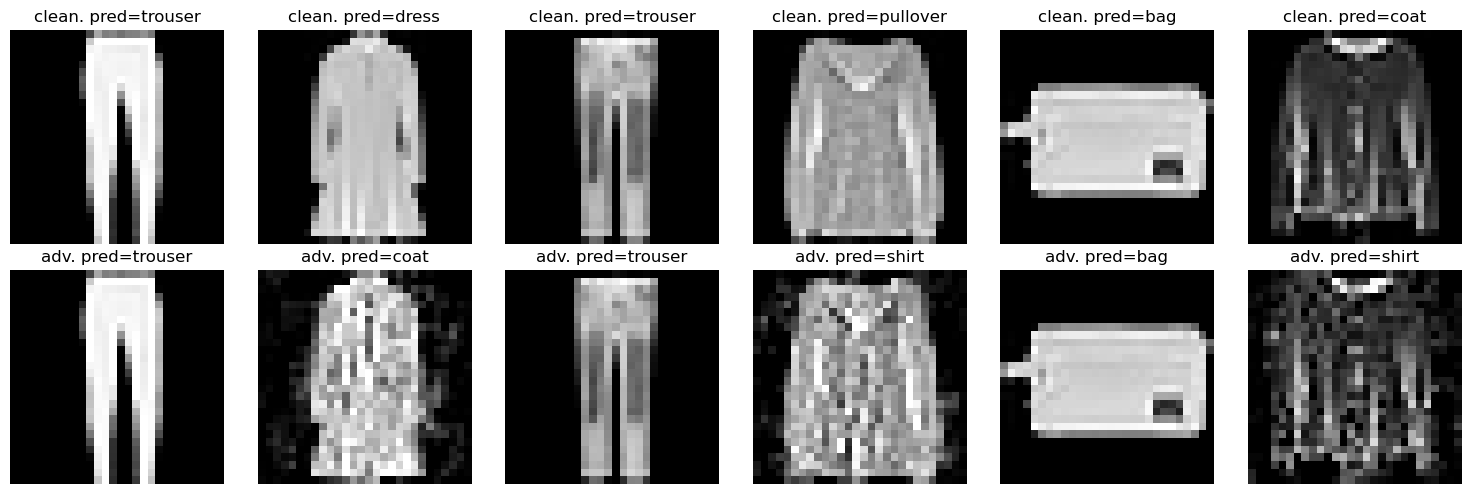

In [9]:
classes = ["t-shirt", "trouser","pullover","dress","coat","sandal","shirt","sneaker","bag","boot"]
net = models.NetA().to(device)
net.load_state_dict(torch.load("netA_standard.pt"))
for data,labels in test_loader:
        data = data.to(device); labels = labels.to(device)

        ###
        # Compute and apply adversarial perturbation to data
        EPS= 4
        ITS= 10
        ALP = 1.85*(EPS/ITS)

        ###
        #adv_data = attacks.PGD_attack(model=net, device=device, dat=data, lbl=labels, eps=EPS, alpha=ALP, iters=ITS, rand_start=True)
        #adv_data = attacks.FGSM_attack(net, device, data, labels, eps=EPS)
        #adv_data = attacks.rFGSM_attack(net, device, data, labels, eps=EPS)
        adv_data = attacks.FGM_L2_attack(net, device, data, labels, eps=EPS)
        # Compute preds
        with torch.no_grad():
            clean_outputs = net(data)
            _,clean_preds = clean_outputs.max(1)
            clean_preds = clean_preds.cpu().squeeze().numpy()
            adv_outputs = net(adv_data)
            _,adv_preds = adv_outputs.max(1)
            adv_preds = adv_preds.cpu().squeeze().numpy()
        
        # Plot some samples
        inds = random.sample(list(range(data.size(0))),6)
        plt.figure(figsize=(15,5))
        for jj in range(6):
            plt.subplot(2,6,jj+1);plt.imshow(data[inds[jj],0].cpu().numpy(),cmap='gray');plt.axis("off");
            plt.title("clean. pred={}".format(classes[clean_preds[inds[jj]]]))
        for jj in range(6):
            plt.subplot(2,6,6+jj+1);plt.imshow(adv_data[inds[jj],0].cpu().numpy(),cmap='gray');plt.axis("off");
            plt.title("adv. pred={}".format(classes[adv_preds[inds[jj]]]))
        plt.tight_layout()
        plt.show()


        break

## Test Attacks - Whitebox & Blackbox

Don't forget to plot accuracy vs. epsilon curves!

In [23]:
## Load pretrained models
whitebox = models.NetA()
blackbox = models.NetB()

whitebox.load_state_dict(torch.load("netA_standard.pt")) # TODO
blackbox.load_state_dict(torch.load("netB_standard.pt")) # TODO

whitebox = whitebox.to(device); blackbox = blackbox.to(device)
whitebox.eval(); blackbox.eval()

test_acc,_ = test_model(whitebox,test_loader,device)
print("Initial Accuracy of Whitebox Model: ",test_acc)
test_acc,_ = test_model(blackbox,test_loader,device)
print("Initial Accuracy of Blackbox Model: ",test_acc)

epsilons = np.linspace(0, 0.1, 11) 
ATK_ITERS = 10
epsilons = np.linspace(0.0, 0.1, 11)
whitebox_accuracies = []
blackbox_accuracies = []

for ATK_EPS in epsilons:
    print(f"Evaluating FGSM attack with ε = {ATK_EPS:.3f}")
    ATK_ALPHA = 1.85*(ATK_EPS/ATK_ITERS)
    whitebox_correct = 0.
    blackbox_correct = 0.
    running_total = 0.
    
    for batch_idx,(data,labels) in enumerate(test_loader):
        data = data.to(device)
        labels = labels.to(device)

        # TODO: Perform adversarial attack here
        #adv_data = attacks.PGD_attack(whitebox, device, data, labels, eps=ATK_EPS, alpha=ATK_ALPHA, iters=ATK_ITERS, rand_start=True)
        #adv_data = attacks.rFGSM_attack(whitebox, device, data, labels, eps=ATK_EPS)
        adv_data = attacks.FGSM_attack(whitebox, device, data, labels, eps=ATK_EPS)
        #adv_data = attacks.random_noise_attack(whitebox, device, data, eps=ATK_EPS)
        # Sanity checking if adversarial example is "legal"
        assert(torch.max(torch.abs(adv_data-data)) <= (ATK_EPS + 1e-5) )
        assert(adv_data.max() == 1.)
        assert(adv_data.min() == 0.)

        # Compute accuracy on perturbed data
        with torch.no_grad():
            # Stat keeping - whitebox
            whitebox_outputs = whitebox(adv_data)
            _,whitebox_preds = whitebox_outputs.max(1)
            whitebox_correct += whitebox_preds.eq(labels).sum().item()
            # Stat keeping - blackbox
            blackbox_outputs = blackbox(adv_data)
            _,blackbox_preds = blackbox_outputs.max(1)
            blackbox_correct += blackbox_preds.eq(labels).sum().item()
            running_total += labels.size(0)

    # Print final
    whitebox_acc = whitebox_correct/running_total
    blackbox_acc = blackbox_correct/running_total
    whitebox_accuracies.append(whitebox_acc)    
    blackbox_accuracies.append(blackbox_acc)

    print("Attack Epsilon: {}; Whitebox Accuracy: {}; Blackbox Accuracy: {}".format(ATK_EPS, whitebox_acc, blackbox_acc))

print("Done!")

Initial Accuracy of Whitebox Model:  0.9243
Initial Accuracy of Blackbox Model:  0.9252
Evaluating FGSM attack with ε = 0.000
Attack Epsilon: 0.0; Whitebox Accuracy: 0.9243; Blackbox Accuracy: 0.9252
Evaluating FGSM attack with ε = 0.010
Attack Epsilon: 0.01; Whitebox Accuracy: 0.6971; Blackbox Accuracy: 0.8762
Evaluating FGSM attack with ε = 0.020
Attack Epsilon: 0.02; Whitebox Accuracy: 0.5716; Blackbox Accuracy: 0.8246
Evaluating FGSM attack with ε = 0.030
Attack Epsilon: 0.03; Whitebox Accuracy: 0.5065; Blackbox Accuracy: 0.7702
Evaluating FGSM attack with ε = 0.040
Attack Epsilon: 0.04; Whitebox Accuracy: 0.4572; Blackbox Accuracy: 0.714
Evaluating FGSM attack with ε = 0.050
Attack Epsilon: 0.05; Whitebox Accuracy: 0.4198; Blackbox Accuracy: 0.6539
Evaluating FGSM attack with ε = 0.060
Attack Epsilon: 0.06; Whitebox Accuracy: 0.3909; Blackbox Accuracy: 0.6013
Evaluating FGSM attack with ε = 0.070
Attack Epsilon: 0.07; Whitebox Accuracy: 0.367; Blackbox Accuracy: 0.5559
Evaluating 

In [21]:
w_pgd_acc = whitebox_accuracies.copy()
b_pgd_acc = blackbox_accuracies.copy()

In [17]:
w_rFGSM_acc = whitebox_accuracies.copy()
b_rFGSM_acc = blackbox_accuracies.copy()

In [24]:
w_FGSM_acc = whitebox_accuracies.copy()
b_FGSM_acc = blackbox_accuracies.copy()

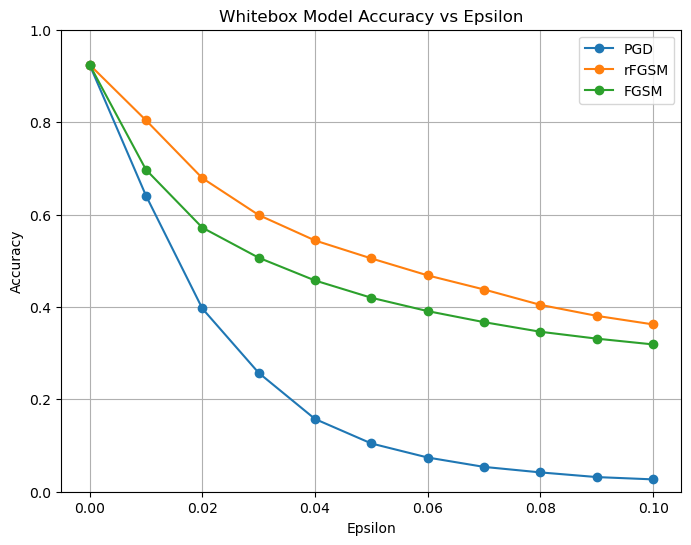

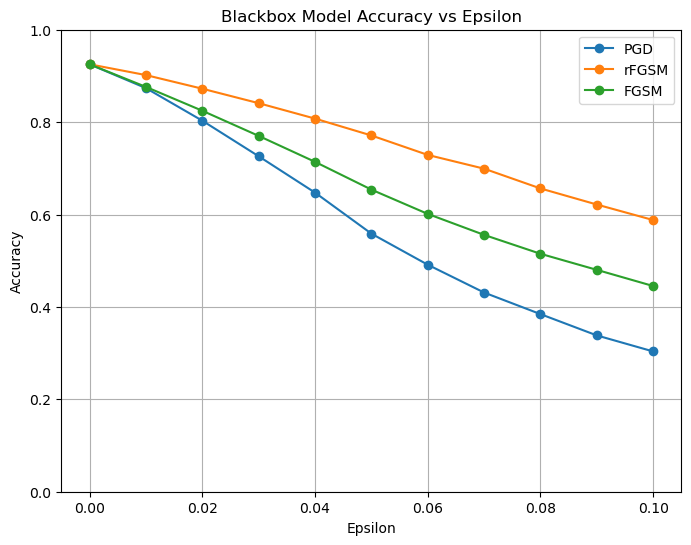

In [25]:
# Plot accuracy vs epsilon for the whitebox model
plt.figure(figsize=(8, 6))
plt.plot(epsilons, w_pgd_acc, marker='o', label='PGD')
plt.plot(epsilons, w_rFGSM_acc, marker='o', label='rFGSM')
plt.plot(epsilons, w_FGSM_acc, marker='o', label='FGSM')
plt.legend()
plt.title('Whitebox Model Accuracy vs Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.grid(True)
plt.show()

# Plot accuracy vs epsilon for the blackbox model
plt.figure(figsize=(8, 6))
plt.plot(epsilons, b_pgd_acc, marker='o', label='PGD')
plt.plot(epsilons, b_rFGSM_acc, marker='o', label='rFGSM')
plt.plot(epsilons, b_FGSM_acc, marker='o', label='FGSM')
plt.legend()
plt.title('Blackbox Model Accuracy vs Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.grid(True)
plt.show()

## Test Robust Models

Don't forget to plot accuracy vs. epsilon curves!

In [38]:
# Load your adversarially trained model (e.g., FGSM, rFGSM, PGD)
whitebox = models.NetA()
whitebox.load_state_dict(torch.load("netA_advtrain_pgd0p1.pt")) # TODO: Load your robust models
whitebox = whitebox.to(device)
whitebox.eval()

test_acc,_ = test_model(whitebox,test_loader,device)
print("Initial Accuracy of Whitebox Model: ",test_acc)

## Test the model against an adversarial attack

# TODO: Set attack parameters here
epsilons = np.arange(0.0, 0.16, 0.02)
ATK_ITERS = 10
accuracies = []

for ATK_EPS in epsilons:
    ATK_ALPHA = 1.85*(ATK_EPS/ATK_ITERS)
    print("\nRunning attack with epsilon: {:.3f}".format(ATK_EPS))
    whitebox_correct = 0.
    running_total = 0.
    for batch_idx,(data,labels) in enumerate(test_loader):
        data = data.to(device)
        labels = labels.to(device)

        # TODO: Perform adversarial attack here
        #adv_data = attacks.rFGSM_attack(whitebox, device, data, labels, eps=ATK_EPS)
        adv_data = attacks.FGSM_attack(whitebox, device, data, labels, eps=ATK_EPS)
        #adv_data = attacks.PGD_attack(whitebox, device, data, labels, eps=ATK_EPS, alpha=ATK_ALPHA, iters=ATK_ITERS, rand_start=True)
        # Sanity checking if adversarial example is "legal"
        assert(torch.max(torch.abs(adv_data-data)) <= (ATK_EPS + 1e-5) )
        assert(adv_data.max() == 1.)
        assert(adv_data.min() == 0.)

        # Compute accuracy on perturbed data
        with torch.no_grad():
            whitebox_outputs = whitebox(adv_data)
            _,whitebox_preds = whitebox_outputs.max(1)
            whitebox_correct += whitebox_preds.eq(labels).sum().item()
            running_total += labels.size(0)

    # Print final
    whitebox_acc = whitebox_correct/running_total
    accuracies.append(whitebox_acc)
    print("Attack Epsilon: {}; Whitebox Accuracy: {}".format(ATK_EPS, whitebox_acc))

print("Done!")

C:\Users\18208\AppData\Local\Temp\ipykernel_27228\47732998.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  whitebox.load_state_dict(torch.load("netA_advtrain_pgd0p1.pt")

Initial Accuracy of Whitebox Model:  0.8693

Running attack with epsilon: 0.000
Attack Epsilon: 0.0; Whitebox Accuracy: 0.8693

Running attack with epsilon: 0.020
Attack Epsilon: 0.02; Whitebox Accuracy: 0.8523

Running attack with epsilon: 0.040
Attack Epsilon: 0.04; Whitebox Accuracy: 0.841

Running attack with epsilon: 0.060
Attack Epsilon: 0.06; Whitebox Accuracy: 0.8302

Running attack with epsilon: 0.080
Attack Epsilon: 0.08; Whitebox Accuracy: 0.8193

Running attack with epsilon: 0.100
Attack Epsilon: 0.1; Whitebox Accuracy: 0.8081

Running attack with epsilon: 0.120
Attack Epsilon: 0.12; Whitebox Accuracy: 0.7771

Running attack with epsilon: 0.140
Attack Epsilon: 0.14; Whitebox Accuracy: 0.6472
Done!


In [35]:
pgd_atk_acc = accuracies.copy()

In [39]:
fgsm_atk_acc = accuracies.copy()

In [37]:
rfgsm_atk_acc = accuracies.copy()

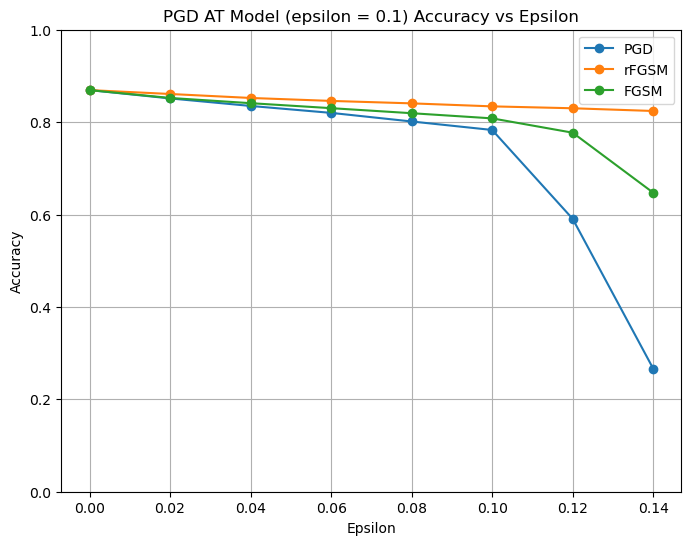

In [40]:
# Plot accuracy vs epsilon for the whitebox model
plt.figure(figsize=(8, 6))
plt.plot(epsilons, pgd_atk_acc, marker='o', label='PGD')
plt.plot(epsilons, rfgsm_atk_acc, marker='o', label='rFGSM')
plt.plot(epsilons, fgsm_atk_acc, marker='o', label='FGSM')
plt.legend()
plt.title('PGD AT Model (epsilon = 0.1) Accuracy vs Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.grid(True)
plt.show()

lab3（f）

In [56]:
def compute_saliency_maps(model, data, labels):
    model.eval()
    data = data.clone().detach().to(device)
    data.requires_grad_()  # track gradients on input

    outputs = model(data)
    loss = F.cross_entropy(outputs, labels)
    loss.backward()

    saliency = data.grad.data.abs()
    return saliency

In [57]:
# Pick a few samples
data_iter = iter(test_loader)
data, labels = next(data_iter)

# Use only first 5 for visualization
samples = data[:5].to(device)
sample_labels = labels[:5].to(device)


In [58]:
# Load standard (non-AT) model
standard_model = models.NetA()
standard_model.load_state_dict(torch.load("netA_standard.pt"))
standard_model = standard_model.to(device)

# Load PGD-AT model
pgd_model = models.NetA()
pgd_model.load_state_dict(torch.load("netA_advtrain_pgd0p1.pt"))
pgd_model = pgd_model.to(device)


C:\Users\18208\AppData\Local\Temp\ipykernel_27228\3345746586.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  standard_model.load_state_dict(torch.load("netA_standard.pt"

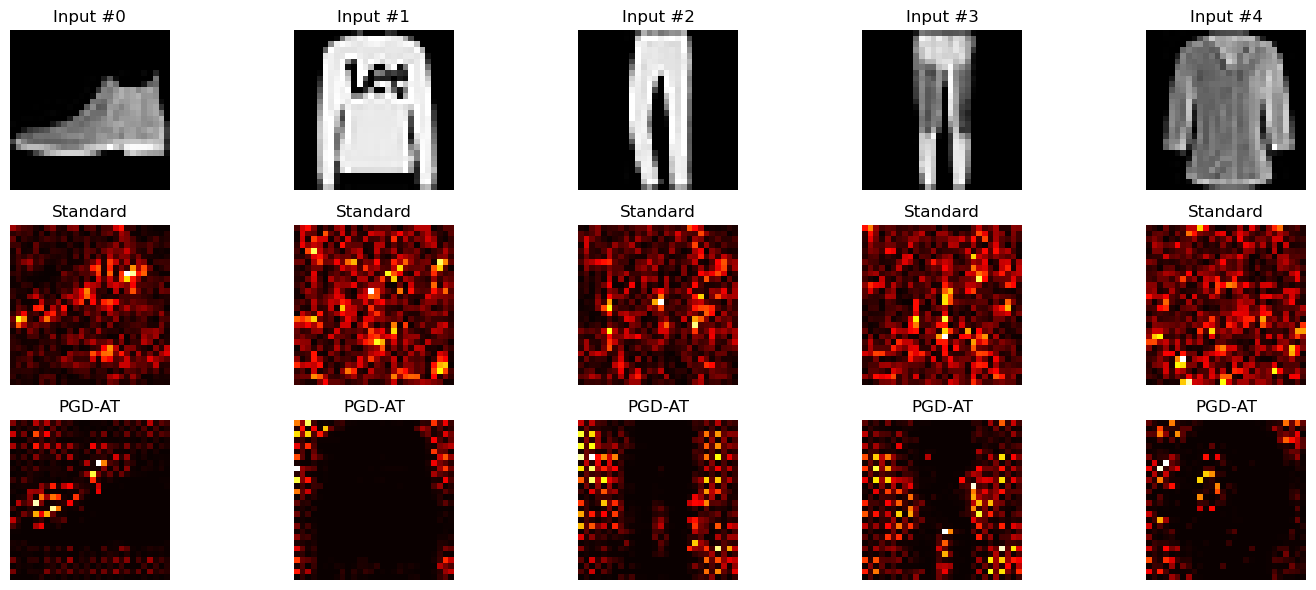

In [59]:
import matplotlib.pyplot as plt
# Compute saliency for standard model
saliency_std = compute_saliency_maps(standard_model, samples, sample_labels)

# Compute saliency for PGD-AT model
saliency_pgd = compute_saliency_maps(pgd_model, samples, sample_labels)
plt.figure(figsize=(15, 6))
for i in range(5):
    # Original
    plt.subplot(3, 5, i + 1)
    plt.imshow(samples[i][0].cpu().numpy(), cmap='gray')
    plt.title(f"Input #{i}")
    plt.axis('off')

    # Standard model saliency
    plt.subplot(3, 5, 5 + i + 1)
    plt.imshow(saliency_std[i][0].cpu().numpy(), cmap='hot')
    plt.title("Standard")
    plt.axis('off')

    # PGD-AT model saliency
    plt.subplot(3, 5, 10 + i + 1)
    plt.imshow(saliency_pgd[i][0].cpu().numpy(), cmap='hot')
    plt.title("PGD-AT")
    plt.axis('off')

plt.tight_layout()
plt.show()
